C:\Users\yasha\AppData\Local\Temp\ipykernel_2024\1383417679.py:83: RuntimeWarning: invalid value encountered in divide
  reconstructed_image /= patch_count
C:\Users\yasha\AppData\Local\Temp\ipykernel_2024\1383417679.py:84: RuntimeWarning: invalid value encountered in cast
  return np.clip(reconstructed_image, 0, 255).astype(np.uint8)


Image: GT_SRGB_010.PNG
PSNR: 30.811029296412883
SSIM: 0.8901582493156468


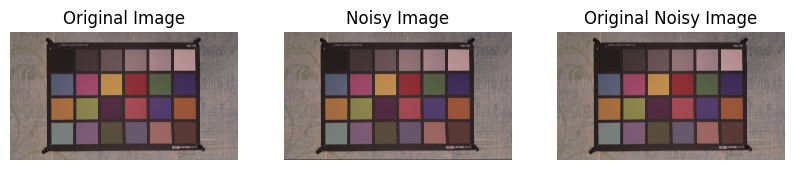

Image: GT_SRGB_010.PNG
PSNR: 26.407717088249104
SSIM: 0.8579917022297758


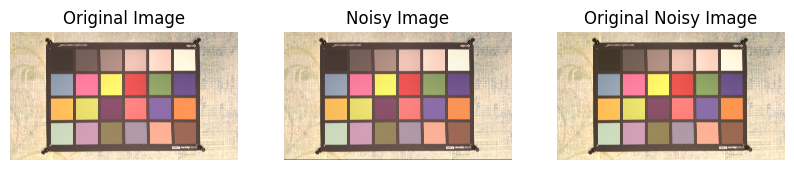

Image: GT_SRGB_010.PNG
PSNR: 32.54196566217959
SSIM: 0.9115461907198309


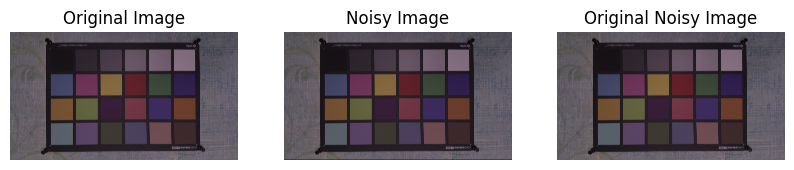

MemoryError: Unable to allocate 122. MiB for an array with shape (3000, 5328) and data type float64

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def add_camera_noise(image, camera='ip'):
    def noise_profiles(camera):
        camera = camera.lower()
        if camera == 'ip':  # iPhone
            iso_set = [100, 200, 400, 800, 1600, 2000]
            cshot = [0.00093595, 0.00104404, 0.00116461, 0.00129911, 0.00144915, 0.00150104]
            cread = [4.697713410870357e-07, 6.904488905478659e-07, 6.739473744228789e-07,
                     6.776787431555864e-07, 6.781983208034481e-07, 6.783184262356993e-07]
        elif camera == 's6':  # Samsung S6 Edge
            iso_set = [100, 200, 400, 800, 1600, 3200]
            cshot = [0.00162521, 0.00256175, 0.00403799, 0.00636492, 0.01003277, 0.01581424]
            cread = [1.1792188420255036e-06, 1.607602896683437e-06, 2.9872611575167216e-06,
                     5.19157563906707e-06, 1.0011034196248119e-05, 2.0652668477786836e-05]
        elif camera == 'gp':  # Google Pixel
            iso_set = [100, 200, 400, 800, 1600, 3200, 6400]
            cshot = [0.00024718, 0.00048489, 0.00095121, 0.001866, 0.00366055, 0.00718092, 0.01408686]
            cread = [1.6819349659429324e-06, 2.0556981890860545e-06, 2.703070976302046e-06,
                     4.116405515789963e-06, 7.569256436438246e-06, 1.5199001098203388e-05, 5.331422827048082e-05]
        elif camera == 'sony':  # Sony A7S2
            iso_set = [800, 1600, 3200]
            cshot = [1.0028880020069384, 1.804521362114003, 3.246920234173119]
            cread = [4.053034401667052, 6.692229120425673, 4.283115294604881]
        elif camera == 'nikon':  # Nikon D850
            iso_set = [800, 1600, 3200]
            cshot = [3.355988883536526, 6.688199969242411, 13.32901281288985]
            cread = [4.4959735547955635, 8.360429952584846, 15.684213053647735]
        else:
            raise NotImplementedError("Camera not supported")
        return iso_set, cshot, cread

    def generate_poisson_(y, k=1):
        y = np.random.poisson(y / k) * k
        return y

    def generate_read_noise(shape, scale):
        read = np.random.normal(0, scale, shape)
        return read

    iso_set, k_set, read_scale_set = noise_profiles(camera)

    # Sample randomly from the noise profile parameters
    i = np.random.choice(len(k_set))
    k, read_scale = k_set[i], read_scale_set[i]

    # Normalize image to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Shot noise (Poisson)
    noisy_shot = generate_poisson_(image, k)
    noisy_shot = np.clip(noisy_shot, 0, 1)

    # Read noise (Gaussian)
    read_noise = generate_read_noise(image.shape, read_scale)

    # Combine shot noise and read noise
    noisy_image = noisy_shot + read_noise

    noisy_image = np.clip(noisy_image * 255, 0, 255).astype(np.uint8)

    return noisy_image

def pattern_aligned_patch_sampling(image, patch_size=32, stride=16):
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i + patch_size, j:j + patch_size]
            patches.append((patch, i, j))
    return patches

def high_bit_reconstruction(patches, image_shape, patch_size=32, stride=16):
    reconstructed_image = np.zeros(image_shape, dtype=np.float32)
    patch_count = np.zeros(image_shape, dtype=np.float32)
    for patch, i, j in patches:
        reconstructed_image[i:i + patch_size, j:j + patch_size] += patch
        patch_count[i:i + patch_size, j:j + patch_size] += 1
    reconstructed_image /= patch_count
    return np.clip(reconstructed_image, 0, 255).astype(np.uint8)

max_count = 0

# Process images in a folder
def process_images_in_folder(folder_path, camera='ip', output_folder='noisy_images'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.startswith('GT_SRGB_010') and file.endswith('.PNG'):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                
                # Pattern-aligned patch sampling
                patches = pattern_aligned_patch_sampling(image)
                
                # Add noise to each patch
                noisy_patches = [(add_camera_noise(patch, camera), i, j) for patch, i, j in patches]
                
                # High-bit reconstruction
                noisy_image = high_bit_reconstruction(noisy_patches, image.shape)
                
                output_path = os.path.join(output_folder, file)
                cv2.imwrite(output_path, noisy_image)

                # PSNR and SSIM
                original_noisy_image_path = os.path.join(root, file.replace('GT_SRGB', 'NOISY_SRGB'))
                if os.path.exists(original_noisy_image_path):
                    original_noisy_image = cv2.imread(original_noisy_image_path)

                    psnr_value = psnr(image, noisy_image)
                    ssim_value = ssim(image, noisy_image, win_size=5, channel_axis=2)

                    print(f"Image: {file}")
                    print(f"PSNR: {psnr_value}")
                    print(f"SSIM: {ssim_value}")

                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 3, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.title("Noisy Image")
                    plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.title("Original Noisy Image")
                    plt.imshow(cv2.cvtColor(original_noisy_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.show()
                else:
                    print(f"Original noisy image not found for: {file}")

                global max_count
                max_count += 1
                if max_count == 10:
                    break
        if max_count == 10:
            break

# Example usage:
if __name__ == '__main__':
    folder_path = 'E:\\archive (1)\\SIDD_Small_sRGB_Only\\Data'
    process_images_in_folder(folder_path, camera='ip')
